In [2]:
import os
import numpy as np
import torch
import torch.nn as nn

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Set paths for clean and contaminated EEG data
clean_dir = "/home/tulgaa/Desktop/emg_dataset/band/clean"
contaminated_dir = "/home/tulgaa/Desktop/emg_dataset/band/Contaminated"

# Define EEG frequency bands
bands = ["Delta_band", "Theta_band", "Alpha_band", "Beta_band", "Gamma_band", "High_Frequencies_band"]

print(f"✅ Clean EEG Directory: {clean_dir}")
print(f"✅ Contaminated EEG Directory: {contaminated_dir}")
print(f"✅ EEG Bands: {bands}")


✅ Using device: cuda
✅ Clean EEG Directory: /home/tulgaa/Desktop/emg_dataset/band/clean
✅ Contaminated EEG Directory: /home/tulgaa/Desktop/emg_dataset/band/Contaminated
✅ EEG Bands: ['Delta_band', 'Theta_band', 'Alpha_band', 'Beta_band', 'Gamma_band', 'High_Frequencies_band']


In [3]:
import torch.nn as nn

class AdvancedLSTM(nn.Module):
    def __init__(self, input_length):
        super(AdvancedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=512, num_layers=3, batch_first=True, dropout=0.3)
        self.layer_norm = nn.LayerNorm(512)  # Match new hidden size
        self.fc = nn.Linear(512, input_length)  # Match new hidden size

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, seq_length, 1)
        x, _ = self.lstm(x)     # LSTM output: (batch_size, seq_length, hidden_size)
        x = self.layer_norm(x[:, -1, :])  # Take last time step and normalize
        x = self.fc(x)          # Final output
        return x


In [4]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

In [5]:
def normalize_signals(data):
    """Normalize the signals to zero mean and unit variance per sample."""
    return (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)
bands = ["Delta_band", "Theta_band", "Alpha_band", "Beta_band", "Gamma_band", "High_Frequencies_band"]
clean_dir = "/home/tulgaa/Desktop/emg_dataset/band/clean"
contaminated_dir = "/home/tulgaa/Desktop/emg_dataset/band/Contaminated"

In [6]:
from sklearn.model_selection import train_test_split

def load_and_split_data(band_name):
    """
    Loads EEG data for a specific frequency band, splits into train and test sets based on SNR levels.
    """
    print(f"\n📌 Loading and Splitting Data for {band_name}...")

    # Load clean EEG data
    clean_band_path = os.path.join(clean_dir, f"{band_name}.npy")
    clean_band = np.load(clean_band_path)

    # Load contaminated EEG data across all SNR levels
    contaminated_band = []
    snr_labels = []

    for snr_folder in sorted(os.listdir(contaminated_dir)):  # Iterate through SNR folders
        contaminated_band_path = os.path.join(contaminated_dir, snr_folder, f"{band_name}.npy")
        contaminated_data = np.load(contaminated_band_path)

        contaminated_band.append(contaminated_data)
        snr_labels.extend([snr_folder] * len(contaminated_data))  # Track SNR levels

    # Convert lists to numpy arrays
    contaminated_band = np.concatenate(contaminated_band, axis=0)
    # Convert string labels ("SNR_-7") to integers (-7)
    
    snr_labels = np.array([int(snr.replace("SNR_", "")) for snr in snr_labels])


    # Ensure clean_band is correctly repeated to match contaminated EEG samples
    clean_band_repeated = np.tile(clean_band, (len(contaminated_band) // len(clean_band) + 1, 1))[:len(contaminated_band)]

    # Stratified Train-Test Split
    train_clean, test_clean, train_contaminated, test_contaminated, snr_labels_train, snr_labels_test = train_test_split(
        clean_band_repeated, contaminated_band, snr_labels, test_size=0.2, stratify=snr_labels, random_state=42
    )

    # Inspect data shapes
    print(f"✅ {band_name} Train Clean Shape: {train_clean.shape}, Test Clean Shape: {test_clean.shape}")
    print(f"✅ {band_name} Train Contaminated Shape: {train_contaminated.shape}, Test Contaminated Shape: {test_contaminated.shape}")
    print(f"✅ {band_name} SNR Labels Train: {np.unique(snr_labels_train)}, Test: {np.unique(snr_labels_test)}")

    return train_clean, train_contaminated, test_clean, test_contaminated, snr_labels_train, snr_labels_test

# Load and split data for each EEG band
train_data = {}
test_data = {}

for band in bands:
    train_clean, train_contaminated, test_clean, test_contaminated, snr_labels_train, snr_labels_test = load_and_split_data(band)
    train_data[band] = (train_clean, train_contaminated)
    test_data[band] = (test_clean, test_contaminated, snr_labels_test)

print("\n✅ All EEG bands successfully loaded and split!")



📌 Loading and Splitting Data for Delta_band...
✅ Delta_band Train Clean Shape: (36112, 1024), Test Clean Shape: (9028, 1024)
✅ Delta_band Train Contaminated Shape: (36112, 1024), Test Contaminated Shape: (9028, 1024)
✅ Delta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Theta_band...
✅ Theta_band Train Clean Shape: (36112, 1024), Test Clean Shape: (9028, 1024)
✅ Theta_band Train Contaminated Shape: (36112, 1024), Test Contaminated Shape: (9028, 1024)
✅ Theta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Alpha_band...
✅ Alpha_band Train Clean Shape: (36112, 1024), Test Clean Shape: (9028, 1024)
✅ Alpha_band Train Contaminated Shape: (36112, 1024), Test Contaminated Shape: (9028, 1024)
✅ Alpha_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Beta_b

In [7]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
def train_and_denoise_band(train_clean, train_contaminated, test_clean, test_contaminated, band_name):
    print(f"\n📌 {band_name} Dataset Shapes:")
    print(f"  Train Clean: {train_clean.shape}, Train Contaminated: {train_contaminated.shape}")
    print(f"  Test Clean: {test_clean.shape}, Test Contaminated: {test_contaminated.shape}")

    train_clean = torch.tensor(train_clean, dtype=torch.float32).unsqueeze(1).to(device)
    test_clean = torch.tensor(test_clean, dtype=torch.float32).unsqueeze(1).to(device)
    train_contaminated = torch.tensor(train_contaminated, dtype=torch.float32).unsqueeze(1).to(device)
    test_contaminated = torch.tensor(test_contaminated, dtype=torch.float32).unsqueeze(1).to(device)

    train_dataset = TensorDataset(train_contaminated, train_clean)
    test_dataset = TensorDataset(test_contaminated, test_clean)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    input_length = train_contaminated.shape[2]
    model = AdvancedLSTM(input_length).to(device)  # ✅ Define the model
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    scaler = torch.cuda.amp.GradScaler()

    early_stopping = EarlyStopping(patience=10, min_delta=1e-4)

    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets.squeeze(1))
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets.squeeze(1))
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")

        early_stopping(avg_test_loss)
        if early_stopping.stop_training:
            print(f"🚀 Early stopping triggered for {band_name} at epoch {epoch + 1}")
            break

    # ✅ Save the trained model for later use
    torch.save(model.state_dict(), f"{band_name}_trained_model.pth")

    # Process test data in smaller batches to reduce memory usage
    with torch.no_grad():
        denoised_batches = []
        batch_size = 256
        for i in range(0, len(test_contaminated), batch_size):
            batch = test_contaminated[i:i+batch_size]
            denoised_batch = model(batch).squeeze(1).cpu().numpy()
            denoised_batches.append(denoised_batch)
        denoised_band = np.concatenate(denoised_batches, axis=0)

    return model, denoised_band, test_clean.cpu().numpy(), test_contaminated.cpu().numpy()


In [8]:
denoised_bands = []
clean_bands = []
contaminated_bands = []
trained_models = {}

print("\n🚀 Training and Denoising Each Band...")

for band in bands:
    print(f"🟢 Processing {band}...")

    # ✅ Load and split data
    train_clean, train_contaminated, test_clean, test_contaminated, _, _ = load_and_split_data(band)

    # ✅ Normalize signals
    train_clean = normalize_signals(train_clean)
    train_contaminated = normalize_signals(train_contaminated)
    test_clean = normalize_signals(test_clean)
    test_contaminated = normalize_signals(test_contaminated)

    # ✅ Train the LSTM model and denoise the test set
    model, denoised_band, clean_band_test, contaminated_band_test = train_and_denoise_band(
        train_clean, train_contaminated, test_clean, test_contaminated, band
    )

    # ✅ Store trained model
    trained_models[band] = model

    # ✅ Store denoised EEG results
    if denoised_band is not None:
        denoised_bands.append(denoised_band)
        clean_bands.append(clean_band_test)
        contaminated_bands.append(contaminated_band_test)
        print(f"✅ {band} Training & Denoising Completed!\n")
    else:
        print(f"❌ {band} failed to produce a denoised signal!")

print("\n✅ All EEG Bands Processed Successfully!")



🚀 Training and Denoising Each Band...
🟢 Processing Delta_band...

📌 Loading and Splitting Data for Delta_band...
✅ Delta_band Train Clean Shape: (36112, 1024), Test Clean Shape: (9028, 1024)
✅ Delta_band Train Contaminated Shape: (36112, 1024), Test Contaminated Shape: (9028, 1024)
✅ Delta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Delta_band Dataset Shapes:
  Train Clean: (36112, 1024), Train Contaminated: (36112, 1024)
  Test Clean: (9028, 1024), Test Contaminated: (9028, 1024)
Epoch 1: Train Loss = 0.9678, Test Loss = 0.9523
Epoch 2: Train Loss = 0.9466, Test Loss = 0.9081
Epoch 3: Train Loss = 0.8867, Test Loss = 0.8501
Epoch 4: Train Loss = 0.8116, Test Loss = 0.7750
Epoch 5: Train Loss = 0.7530, Test Loss = 0.7519
Epoch 6: Train Loss = 0.6906, Test Loss = 0.7425
Epoch 7: Train Loss = 0.6459, Test Loss = 0.6444
Epoch 8: Train Loss = 0.5986, Test Loss = 0.6035
Epoch 9: Train Loss = 0.5535, Test Loss = 0.5465
Epoch 10: Train Los

In [9]:
print(len(contaminated_bands ))  # Prints number of elements in the list


6


In [10]:
# ✅ Check shapes of stored bands
print("\n🚀 Checking stored EEG data shapes...")

# Clean EEG
if len(clean_bands) > 0:
    print(f"✅ First clean EEG shape: {clean_bands[0].shape}")
else:
    print("❌ clean_bands is empty!")

# Denoised EEG
if len(denoised_bands) > 0:
    print(f"✅ First denoised EEG shape: {denoised_bands[0].shape}")
else:
    print("❌ denoised_bands is empty!")

# Contaminated EEG
if len(contaminated_bands) > 0:
    print(f"✅ First contaminated EEG shape: {contaminated_bands[0].shape}")
else:
    print("❌ contaminated_bands is empty!")



🚀 Checking stored EEG data shapes...
✅ First clean EEG shape: (9028, 1, 1024)
✅ First denoised EEG shape: (9028, 1024)
✅ First contaminated EEG shape: (9028, 1, 1024)


In [11]:
import numpy as np

# ✅ Convert lists to NumPy arrays
clean_bands = np.array(clean_bands)  # Shape: (6, samples, 512)
denoised_bands = np.array(denoised_bands)  # Shape: (6, samples, 512)

# ✅ Reconstruct full EEG signals by summing across frequency bands
denoised_eeg = np.sum(denoised_bands, axis=0)  # Sum across frequency bands
clean_eeg = np.sum(clean_bands, axis=0)

# ✅ Ensure correct shape
if clean_eeg.ndim == 3:
    clean_eeg = clean_eeg.squeeze(1)  # Only squeeze if it has an extra dimension

print(f"✅ Reconstructed EEG: Denoised EEG Shape: {denoised_eeg.shape}, Clean EEG Shape: {clean_eeg.shape}")


✅ Reconstructed EEG: Denoised EEG Shape: (9028, 1024), Clean EEG Shape: (9028, 1024)


In [12]:
import numpy as np
from scipy.signal import welch

# Compute RRMSE in time domain
def compute_rrmse_t(clean, denoised):
    per_sample_rrmse = np.sqrt(np.sum((clean - denoised) ** 2, axis=1) / np.sum(clean ** 2, axis=1))
    return np.mean(per_sample_rrmse)

# Compute RRMSE in frequency domain using Power Spectral Density (PSD)
def compute_rrmse_s(clean, denoised, fs=512):
    f_clean, psd_clean = welch(clean.flatten(), fs=fs, nperseg=512)
    f_denoised, psd_denoised = welch(denoised.flatten(), fs=fs, nperseg=512)
    return np.sqrt(np.sum((psd_clean - psd_denoised) ** 2) / np.sum(psd_clean ** 2))

# Compute Correlation Coefficient (CC)
def compute_cc(clean, denoised):
    return np.corrcoef(clean.flatten(), denoised.flatten())[0, 1]

print("✅ Evaluation functions loaded!") 

✅ Evaluation functions loaded!


In [13]:
import pandas as pd

# Store evaluation results per SNR level
snr_metrics = {}

# Ensure snr_labels_test is a NumPy array
snr_labels_test = np.array(snr_labels_test).flatten()

# Evaluate each SNR level separately
for snr in np.unique(snr_labels_test):
    indices = np.where(snr_labels_test == snr)[0]  # Get test samples for this SNR

    clean_snr = clean_eeg[indices]
    denoised_snr = denoised_eeg[indices]

    # Compute evaluation metrics
    rrmse_t = compute_rrmse_t(clean_snr, denoised_snr)
    rrmse_s = compute_rrmse_s(clean_snr, denoised_snr, fs=512)
    cc = compute_cc(clean_snr, denoised_snr)
    ts_metric = 10 * np.log10(1 / (rrmse_t + rrmse_s))

    # Store metrics per SNR
    snr_metrics[snr] = {"RRMSE-T": rrmse_t, "RRMSE-S": rrmse_s, "CC": cc, "T&S Metric (dB)": ts_metric}

    print(f"  ✅ SNR {snr}: RRMSE-T = {rrmse_t:.4f}, RRMSE-S = {rrmse_s:.4f}, CC = {cc:.4f}, T&S Metric = {ts_metric:.4f} dB")

# Convert results to DataFrame for better visualization
df_snr_metrics = pd.DataFrame.from_dict(snr_metrics, orient="index")
df_snr_metrics.index.name = "SNR Level"

# Display results


  ✅ SNR -7: RRMSE-T = 0.4030, RRMSE-S = 0.2547, CC = 0.9100, T&S Metric = 1.8201 dB
  ✅ SNR -6: RRMSE-T = 0.3563, RRMSE-S = 0.2291, CC = 0.9306, T&S Metric = 2.3255 dB
  ✅ SNR -5: RRMSE-T = 0.3311, RRMSE-S = 0.2153, CC = 0.9404, T&S Metric = 2.6247 dB
  ✅ SNR -4: RRMSE-T = 0.3178, RRMSE-S = 0.2088, CC = 0.9451, T&S Metric = 2.7854 dB
  ✅ SNR -3: RRMSE-T = 0.3079, RRMSE-S = 0.2045, CC = 0.9487, T&S Metric = 2.9041 dB
  ✅ SNR -2: RRMSE-T = 0.2971, RRMSE-S = 0.1907, CC = 0.9521, T&S Metric = 3.1173 dB
  ✅ SNR -1: RRMSE-T = 0.2874, RRMSE-S = 0.1796, CC = 0.9551, T&S Metric = 3.3066 dB
  ✅ SNR 0: RRMSE-T = 0.2910, RRMSE-S = 0.1867, CC = 0.9541, T&S Metric = 3.2080 dB
  ✅ SNR 1: RRMSE-T = 0.2953, RRMSE-S = 0.1872, CC = 0.9525, T&S Metric = 3.1654 dB
  ✅ SNR 2: RRMSE-T = 0.3184, RRMSE-S = 0.1824, CC = 0.9440, T&S Metric = 3.0034 dB


In [14]:
# Compute the average of all SNR-based metrics
avg_rrmse_t = np.mean([metrics["RRMSE-T"] for metrics in snr_metrics.values()])
avg_rrmse_s = np.mean([metrics["RRMSE-S"] for metrics in snr_metrics.values()])
avg_cc = np.mean([metrics["CC"] for metrics in snr_metrics.values()])
avg_ts_metric = np.mean([metrics["T&S Metric (dB)"] for metrics in snr_metrics.values()])

# Print the final summary
print("\n==== Final Evaluation Summary ====")
print(f"✅ Average RRMSE-T: {avg_rrmse_t:.4f}")
print(f"✅ Average RRMSE-S: {avg_rrmse_s:.4f}")
print(f"✅ Average CC: {avg_cc:.4f}")
print(f"✅ Average T&S Metric (dB): {avg_ts_metric:.4f}")

# Create DataFrame for display



==== Final Evaluation Summary ====
✅ Average RRMSE-T: 0.3205
✅ Average RRMSE-S: 0.2039
✅ Average CC: 0.9432
✅ Average T&S Metric (dB): 2.8260


✅ SNR Labels Shape: (9028,), Clean EEG Shape: (9028, 1024), Denoised EEG Shape: (9028, 1024)
✅ Converted SNR Labels: [ 0 -1  1 -6 -7 -6  2  1 -3 -1] ...

📊 Found 903 test samples for SNR Level -5
✅ SNR Level -5 indices in test set: [10, 17, 22, 44, 54, 56, 83, 84, 93, 101, 107, 116, 117, 126, 141, 146, 153, 157, 162, 176, 196, 198, 209, 211, 228, 233, 254, 262, 272, 296, 302, 306, 319, 322, 327, 333, 341, 345, 349, 364, 374, 403, 410, 440, 448, 456, 457, 467, 469, 474, 482, 484, 494, 499, 525, 548, 556, 574, 580, 581, 587, 590, 614, 615, 616, 631, 642, 667, 675, 682, 684, 685, 741, 756, 759, 765, 767, 772, 777, 794, 798, 804, 807, 808, 835, 836, 853, 856, 860, 865, 876, 893, 894, 895, 905, 917, 932, 942, 954, 956, 958, 983, 986, 991, 1000, 1004, 1009, 1019, 1025, 1034, 1036, 1056, 1057, 1075, 1077, 1079, 1125, 1128, 1131, 1141, 1142, 1148, 1157, 1159, 1163, 1172, 1190, 1196, 1200, 1205, 1211, 1212, 1236, 1237, 1254, 1258, 1265, 1269, 1288, 1298, 1305, 1307, 1309, 1317, 1347, 1355, 1359

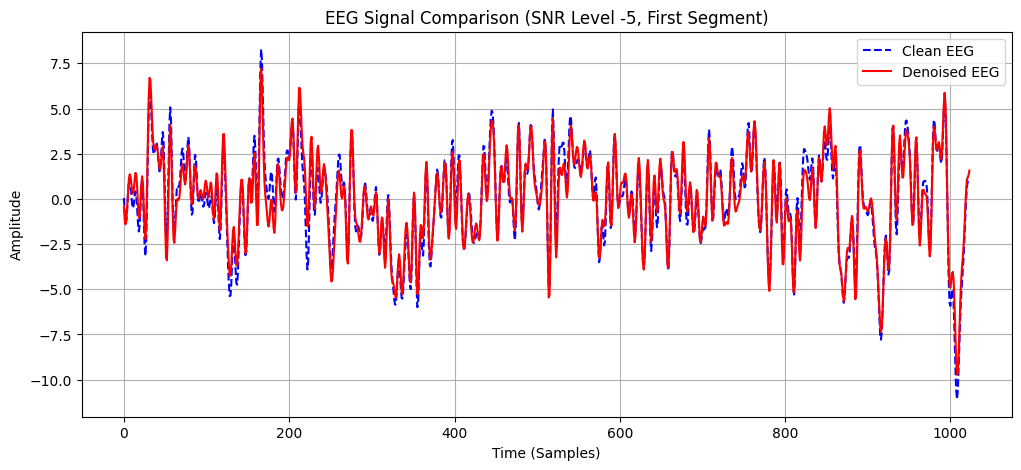

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure required variables are loaded
try:
    print(f"✅ SNR Labels Shape: {snr_labels_test.shape}, Clean EEG Shape: {clean_eeg.shape}, Denoised EEG Shape: {denoised_eeg.shape}")
except NameError:
    print("❌ Variables are not defined. Re-run the data preparation and evaluation cells.")

# ✅ Convert SNR labels to integers safely
try:
    snr_labels_test_int = np.array([int(str(snr).replace("SNR_", "")) for snr in snr_labels_test])
    print(f"✅ Converted SNR Labels: {snr_labels_test_int[:10]} ...")  # Show first 10 for debugging
except Exception as e:
    print(f"❌ Error converting SNR labels: {e}")

# Set SNR level to check
snr_level = -5 

# ✅ Extract indices of test samples for the selected SNR level
snr_indices = np.where(snr_labels_test_int == snr_level)[0]

# ✅ Handle missing SNR level
if len(snr_indices) == 0:
    print(f"❌ No test samples found for SNR Level {snr_level}.")
else:
    print(f"\n📊 Found {len(snr_indices)} test samples for SNR Level {snr_level}")
    print(f"✅ SNR Level {snr_level} indices in test set: {snr_indices.tolist()}")

    # ✅ Select the first segment
    first_segment_idx = snr_indices[2]

    # ✅ Extract EEG segments
    clean_segment = clean_eeg[first_segment_idx]
    denoised_segment = denoised_eeg[first_segment_idx]

    # ✅ Reconstruct Contaminated EEG by summing all frequency bands
    contaminated_bands = [test_data[band][1] for band in bands]
    contaminated_eeg = np.sum(contaminated_bands, axis=0)
    contaminated_segment = contaminated_eeg[first_segment_idx]

    # ✅ Plot EEG signals
    plt.figure(figsize=(12, 5))
    plt.plot(clean_segment, label="Clean EEG", linestyle="dashed", color="blue", linewidth=1.5)
    plt.plot(denoised_segment, label="Denoised EEG", linestyle="solid", color="red", linewidth=1.5)
    #plt.plot(contaminated_segment, label="Contaminated EEG", linestyle="dotted", color="green", linewidth=1.5)
    
    plt.title(f"EEG Signal Comparison (SNR Level {snr_level}, First Segment)")
    plt.xlabel("Time (Samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()


In [16]:
print("🟢 Denoised EEG Plotting Points:")
for i, value in enumerate(denoised_segment):
    print(f"({i}, {value})")

🟢 Denoised EEG Plotting Points:
(0, -0.4451380968093872)
(1, -1.1765213012695312)
(2, -1.4051567316055298)
(3, -1.1447737216949463)
(4, -0.41688424348831177)
(5, 0.4040009379386902)
(6, 1.0895541906356812)
(7, 1.3663694858551025)
(8, 1.2431347370147705)
(9, 0.8339712023735046)
(10, 0.42251837253570557)
(11, 0.2868238687515259)
(12, 0.5568495392799377)
(13, 1.0609605312347412)
(14, 1.4409878253936768)
(15, 1.3298406600952148)
(16, 0.638963520526886)
(17, -0.3396855592727661)
(18, -1.043419599533081)
(19, -1.0357468128204346)
(20, -0.27935922145843506)
(21, 0.7200616598129272)
(22, 1.2512743473052979)
(23, 0.829090416431427)
(24, -0.4037950336933136)
(25, -1.7226990461349487)
(26, -2.223803758621216)
(27, -1.3478271961212158)
(28, 0.7766810655593872)
(29, 3.408945083618164)
(30, 5.5995588302612305)
(31, 6.699569225311279)
(32, 6.5990400314331055)
(33, 5.647486686706543)
(34, 4.435766696929932)
(35, 3.430694103240967)
(36, 2.8749301433563232)
(37, 2.7351598739624023)
(38, 2.84592127799987

✅ SNR Labels Shape: (6800,), Clean EEG Shape: (6800, 512), Denoised EEG Shape: (6800, 512)
✅ Converted SNR Labels: [-7 -7 -2 -4  2  1  2 -2 -2 -4] ...

📊 Found 680 test samples for SNR Level -5
✅ SNR Level -5 indices in test set: [26, 29, 51, 61, 79, 82, 89, 91, 94, 95, 108, 115, 120, 129, 136, 159, 161, 167, 186, 188, 194, 212, 220, 225, 235, 240, 248, 279, 284, 315, 318, 325, 331, 333, 336, 345, 354, 369, 371, 372, 379, 381, 386, 406, 408, 416, 419, 421, 433, 439, 453, 460, 484, 488, 490, 506, 508, 512, 549, 574, 598, 605, 620, 632, 635, 691, 695, 696, 713, 724, 726, 734, 738, 749, 750, 752, 753, 756, 767, 775, 783, 793, 800, 801, 817, 818, 831, 840, 858, 865, 882, 883, 902, 914, 936, 940, 960, 965, 969, 977, 978, 979, 981, 982, 1004, 1009, 1019, 1020, 1036, 1044, 1052, 1070, 1079, 1084, 1086, 1088, 1108, 1111, 1112, 1116, 1117, 1129, 1151, 1158, 1168, 1191, 1194, 1208, 1216, 1244, 1245, 1251, 1267, 1276, 1292, 1293, 1308, 1316, 1331, 1359, 1363, 1365, 1377, 1384, 1447, 1450, 1457, 1

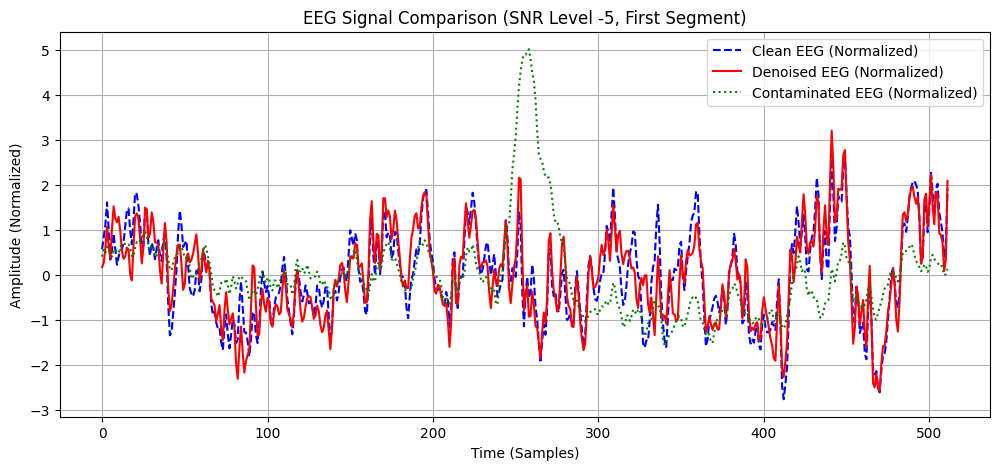

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_signals(data):
    """Normalize the signals to zero mean and unit variance per sample."""
    return (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)

# Ensure required variables are loaded
try:
    print(f"✅ SNR Labels Shape: {snr_labels_test.shape}, Clean EEG Shape: {clean_eeg.shape}, Denoised EEG Shape: {denoised_eeg.shape}")
except NameError:
    print("❌ Variables are not defined. Re-run the data preparation and evaluation cells.")
    raise

# ✅ Convert SNR labels to integers safely
try:
    snr_labels_test_int = np.array([int(str(snr).replace("SNR_", "")) for snr in snr_labels_test])
    print(f"✅ Converted SNR Labels: {snr_labels_test_int[:10]} ...")  # Show first 10 for debugging
except Exception as e:
    print(f"❌ Error converting SNR labels: {e}")
    raise

# Set SNR level to check
snr_level = -5  

# ✅ Extract indices of test samples for the selected SNR level
snr_indices = np.where(snr_labels_test_int == snr_level)[0]

# ✅ Handle missing SNR level
if len(snr_indices) == 0:
    print(f"❌ No test samples found for SNR Level {snr_level}.")
else:
    print(f"\n📊 Found {len(snr_indices)} test samples for SNR Level {snr_level}")
    print(f"✅ SNR Level {snr_level} indices in test set: {snr_indices.tolist()}")

    # ✅ Select the first segment
    first_segment_idx = snr_indices[2]

    # ✅ Extract EEG segments safely
    try:
        clean_segment = clean_eeg[first_segment_idx]
        denoised_segment = denoised_eeg[first_segment_idx]
    except IndexError as e:
        print(f"❌ Index error when extracting EEG segments: {e}")
        raise

    # ✅ Reconstruct Contaminated EEG by summing all frequency bands
    try:
        contaminated_bands = [test_data[band][1] for band in bands if band in test_data]
        contaminated_eeg = np.sum(contaminated_bands, axis=0)

        # ✅ Normalize ALL signals (Clean, Denoised, and Contaminated)
        clean_eeg = normalize_signals(clean_eeg)
        denoised_eeg = normalize_signals(denoised_eeg)
        contaminated_eeg = normalize_signals(contaminated_eeg)

        # Extract the normalized segments
        clean_segment = clean_eeg[first_segment_idx]
        denoised_segment = denoised_eeg[first_segment_idx]
        contaminated_segment = contaminated_eeg[first_segment_idx]

    except Exception as e:
        print(f"❌ Error reconstructing contaminated EEG: {e}")
        raise

    # ✅ Check normalization consistency
    print(f"🔎 Clean EEG (Normalized): Mean = {np.mean(clean_segment):.4f}, Std = {np.std(clean_segment):.4f}")
    print(f"🔎 Denoised EEG (Normalized): Mean = {np.mean(denoised_segment):.4f}, Std = {np.std(denoised_segment):.4f}")
    print(f"🔎 Contaminated EEG (Normalized): Mean = {np.mean(contaminated_segment):.4f}, Std = {np.std(contaminated_segment):.4f}")

    # ✅ Plot EEG signals with improved visualization
    plt.figure(figsize=(12, 5))
    plt.plot(clean_segment, label="Clean EEG (Normalized)", linestyle="dashed", color="blue", linewidth=1.5)
    plt.plot(denoised_segment, label="Denoised EEG (Normalized)", linestyle="solid", color="red", linewidth=1.5)
    plt.plot(contaminated_segment, label="Contaminated EEG (Normalized)", linestyle="dotted", color="green", linewidth=1.5)

    plt.title(f"EEG Signal Comparison (SNR Level {snr_level}, First Segment)")
    plt.xlabel("Time (Samples)")
    plt.ylabel("Amplitude (Normalized)")
    plt.legend()
    plt.grid(True)
    plt.show()


🔍 Original Clean Mean: 0.0000, Std: 1.0000
🔍 Denormalized Clean Mean: 0.0000, Std: 1.0000
🔍 Original Denoised Mean: 0.0000, Std: 1.0000
🔍 Denormalized Denoised Mean: 0.0000, Std: 1.0000
🔍 Original Contaminated Mean: 0.0000, Std: 1.0000
🔍 Denormalized Contaminated Mean: 0.0000, Std: 1.0000


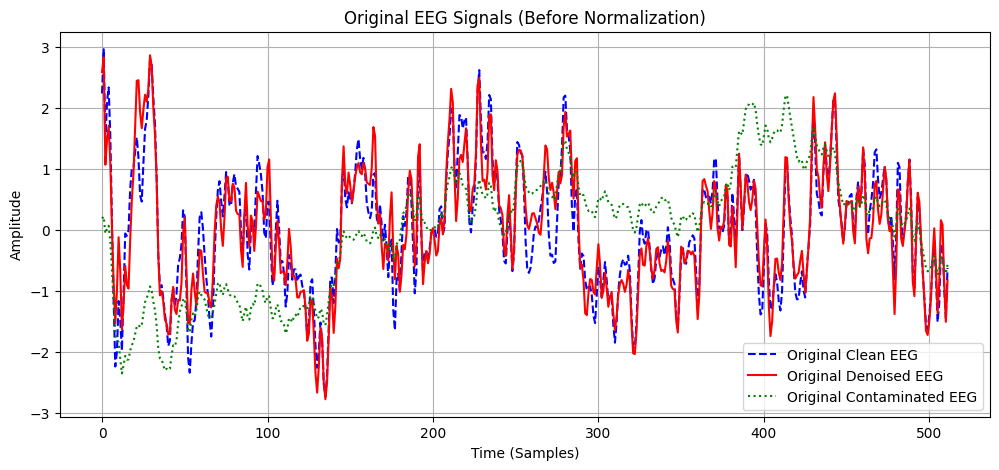

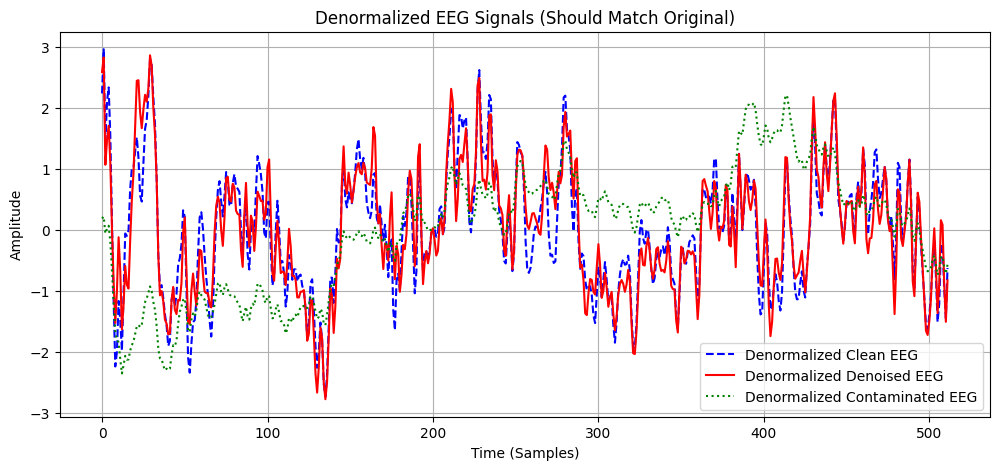

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_signals(data):
    """Normalize signals to zero mean and unit variance per sample."""
    mean = np.mean(data, axis=1, keepdims=True)  # Compute mean per sample
    std = np.std(data, axis=1, keepdims=True)  # Compute std per sample
    return (data - mean) / std, mean, std  # Return normalized data and original mean, std

def denormalize_signals(normalized_data, mean, std):
    """Denormalize signals using original mean and std."""
    return (normalized_data * std) + mean  # Reverse normalization

# ✅ Store original EEG signals before normalization
original_clean_eeg = clean_eeg.copy()
original_denoised_eeg = denoised_eeg.copy()
original_contaminated_eeg = contaminated_eeg.copy()

# ✅ Normalize all EEG signals and store their means/stds
clean_eeg, clean_mean, clean_std = normalize_signals(clean_eeg)
denoised_eeg, denoised_mean, denoised_std = normalize_signals(denoised_eeg)
contaminated_eeg, contaminated_mean, contaminated_std = normalize_signals(contaminated_eeg)

# ✅ Extract a specific test segment (first segment for SNR Level -5)
first_segment_idx = snr_indices[0]
# ✅ Extract the corresponding mean and std for denormalization
clean_segment = clean_eeg[first_segment_idx]
denoised_segment = denoised_eeg[first_segment_idx]
contaminated_segment = contaminated_eeg[first_segment_idx]

# ✅ Extract correct original mean & std per segment
clean_mean_segment = clean_mean[first_segment_idx]
clean_std_segment = clean_std[first_segment_idx]

denoised_mean_segment = denoised_mean[first_segment_idx]
denoised_std_segment = denoised_std[first_segment_idx]

contaminated_mean_segment = contaminated_mean[first_segment_idx]
contaminated_std_segment = contaminated_std[first_segment_idx]

# ✅ Denormalize the signals
denorm_clean_segment = denormalize_signals(clean_segment, clean_mean_segment, clean_std_segment)
denorm_denoised_segment = denormalize_signals(denoised_segment, denoised_mean_segment, denoised_std_segment)
denorm_contaminated_segment = denormalize_signals(contaminated_segment, contaminated_mean_segment, contaminated_std_segment)

# ✅ Extract original (unnormalized) test segments
original_clean_segment = original_clean_eeg[first_segment_idx]
original_denoised_segment = original_denoised_eeg[first_segment_idx]
original_contaminated_segment = original_contaminated_eeg[first_segment_idx]

# ✅ Debugging: Check denormalization correctness
print(f"🔍 Original Clean Mean: {np.mean(original_clean_segment):.4f}, Std: {np.std(original_clean_segment):.4f}")
print(f"🔍 Denormalized Clean Mean: {np.mean(denorm_clean_segment):.4f}, Std: {np.std(denorm_clean_segment):.4f}")

print(f"🔍 Original Denoised Mean: {np.mean(original_denoised_segment):.4f}, Std: {np.std(original_denoised_segment):.4f}")
print(f"🔍 Denormalized Denoised Mean: {np.mean(denorm_denoised_segment):.4f}, Std: {np.std(denorm_denoised_segment):.4f}")

print(f"🔍 Original Contaminated Mean: {np.mean(original_contaminated_segment):.4f}, Std: {np.std(original_contaminated_segment):.4f}")
print(f"🔍 Denormalized Contaminated Mean: {np.mean(denorm_contaminated_segment):.4f}, Std: {np.std(denorm_contaminated_segment):.4f}")

# ✅ Plot original signals
plt.figure(figsize=(12, 5))
plt.plot(original_clean_segment, label="Original Clean EEG", linestyle="dashed", color="blue", linewidth=1.5)
plt.plot(original_denoised_segment, label="Original Denoised EEG", linestyle="solid", color="red", linewidth=1.5)
plt.plot(original_contaminated_segment, label="Original Contaminated EEG", linestyle="dotted", color="green", linewidth=1.5)

plt.title("Original EEG Signals (Before Normalization)")
plt.xlabel("Time (Samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Plot denormalized signals
plt.figure(figsize=(12, 5))
plt.plot(denorm_clean_segment, label="Denormalized Clean EEG", linestyle="dashed", color="blue", linewidth=1.5)
plt.plot(denorm_denoised_segment, label="Denormalized Denoised EEG", linestyle="solid", color="red", linewidth=1.5)
plt.plot(denorm_contaminated_segment, label="Denormalized Contaminated EEG", linestyle="dotted", color="green", linewidth=1.5)

plt.title("Denormalized EEG Signals (Should Match Original)")
plt.xlabel("Time (Samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()
